# BirdCLEF2025+:Sound Event Visualisations


ENSEMBLE notebook based on BirdCLEF2025+:Sound Event Visualisations



In [1]:
import os
import sys
import time
import torch
import torchaudio
import torchaudio.transforms as AT
#sys.path.append("/kaggle/input/birdclef2025-utils")
#from birdclef2025_utils import get_results

<ipython-input-2-4145861162c1>:34: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  correlation = all_preds.groupby(axis=1, level=0).mean().corr()


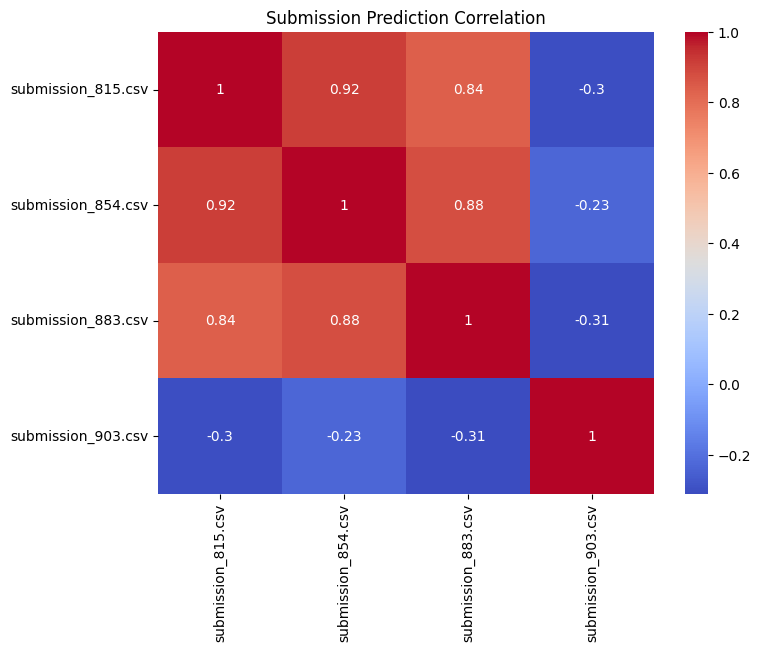

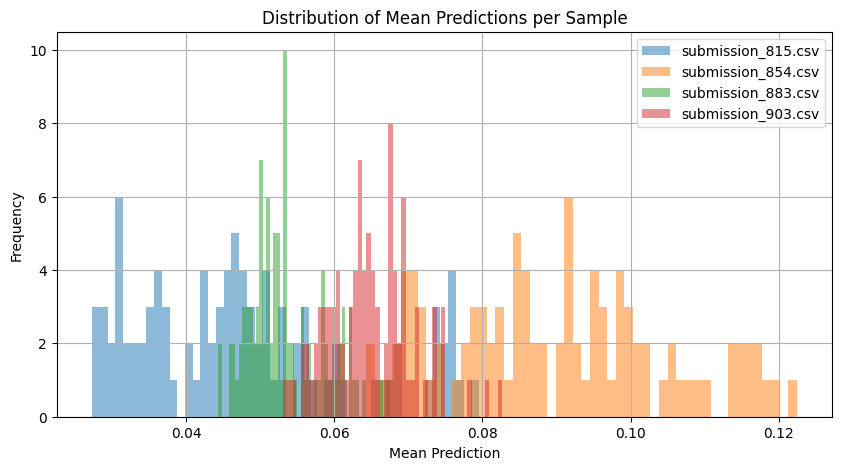

Submission file saved as submission.csv using strategy: geom_mean


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# === CONFIGURATION ===
# Choose one of: 'mean', 'median', 'weighted', 'rank', 'max', 'geom_mean', 'threshold', 'top'
ensemble_strategy = 'geom_mean'

# Directory and file paths
submission_dir = Path("/kaggle/input/birdclef-2025submission-csvtrain-soundscapes")
submission_files = [
    "submission_815.csv",
    "submission_854.csv",
    "submission_883.csv",
    "submission_903.csv"
]

# Load submissions with associated scores
submissions = {}
scores = {}
for fname in submission_files:
    score = int(fname.split("_")[1].split(".")[0])
    df = pd.read_csv(submission_dir / fname, index_col="row_id")
    submissions[fname] = df
    scores[fname] = score

# Combine all submission DataFrames into a single panel
all_preds = pd.concat(submissions.values(), axis=1, keys=submissions.keys())

# EDA: Check correlation between different submissions
mean_preds = {fname: df.mean().mean() for fname, df in submissions.items()}
correlation = all_preds.groupby(axis=1, level=0).mean().corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Submission Prediction Correlation")
plt.show()

# EDA: Histogram of average predicted probability per submission
plt.figure(figsize=(10, 5))
for fname, df in submissions.items():
    df.mean(axis=1).hist(alpha=0.5, bins=50, label=fname)
plt.legend()
plt.title("Distribution of Mean Predictions per Sample")
plt.xlabel("Mean Prediction")
plt.ylabel("Frequency")
plt.show()

# === ENSEMBLE STRATEGIES ===
if ensemble_strategy == 'mean':
    ensemble = sum(submissions.values()) / len(submissions)
elif ensemble_strategy == 'median':
    ensemble = pd.concat(submissions.values()).groupby(level=0).median()
elif ensemble_strategy == 'weighted':
    total_score = sum(scores.values())
    ensemble = sum(
        submissions[fname] * (score / total_score) for fname, score in scores.items()
    )
elif ensemble_strategy == 'rank':
    ranked = [df.rank(axis=1) for df in submissions.values()]
    ensemble = sum(ranked) / len(ranked)
    ensemble = ensemble.div(ensemble.sum(axis=1), axis=0)  # Normalize
elif ensemble_strategy == 'max':
    ensemble = pd.concat(submissions.values()).groupby(level=0).max()
elif ensemble_strategy == 'geom_mean':
    ensemble = np.exp(sum(np.log(df + 1e-9) for df in submissions.values()) / len(submissions))
    first_df = next(iter(submissions.values()))
    ensemble = pd.DataFrame(ensemble, index=first_df.index, columns=first_df.columns)
elif ensemble_strategy == 'threshold':
    ensemble = sum(submissions.values()) / len(submissions)
    ensemble = ensemble.clip(lower=0.001)  # Boost low probabilities
elif ensemble_strategy == 'top':
    top_file = max(scores, key=scores.get)
    ensemble = submissions[top_file]
else:
    raise ValueError("Invalid ensemble strategy selected.")

# Save final submission
ensemble.to_csv("submission.csv")
print(f"Submission file saved as submission.csv using strategy: {ensemble_strategy}")
